## Illustrative Example Script

The Illustrative Example data is from six fixed cameras on top a 43-m tower (known as the Argus Tower) at the Army Corps of Engineers Field Research Facility in Duck, NC. Single oblique frames from one each of the 6 Argus cameras were subsampled from oblique videos that were initially 17 minutes long and captured at 2 frames per second. Each video was recorded simultaneously. Extrinsic and intrinsic values for each camera are provided in both direct linear transform coefficient format as well as in CIRN convention. 

Example images are contained within the CoastalImageLib repository, in a folder entitled 'ExampleData'. The full link to these images is: https://github.com/mailemccann/CoastalImageLib/ExampleData

Let's start with our imports. 

Ensure that each package is installed prior to running your script, in addition to the package dependencies described in section 2 of the CoastalImageLib User Manual. 
Suggested install is via 'pip install ___'

In [1]:
# CoastalImageLib imports
import corefunctions as cf
import supportfunctions as sf

# External imports
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import imageio
import os

Now, we can initialize the strings that contain our file information.

In [2]:
# Image, camera data, and video locations
# Change this string to match the location on your computer containing the subfolders of camera data
folder = 'ExampleData'

# These are the 'tags' for each camera. They are used
# to distinguish between camera files, as well as
# intrinsic and extrinsic values contained in the .yaml file, 
# loaded in the next code block.
cams = ['c1','c2','c3','c4','c5','c6']

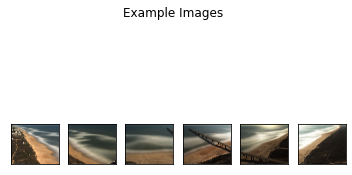

In [3]:
# This is our list of strings containing the file name and
# locations for each FRAME (.jpg file) file we want to rectify

file_base = '1444314601.Thu.Oct.08_14_30_01.GMT.2015.argus02b.' 

# Frames
image_list = [os.path.join(folder,i,(file_base + i + '.timex.jpg')) for i in cams]

# Display our oblique frames
fig, axs = plt.subplots(1, 6)

for ind, im_name in enumerate(image_list):
    image = imageio.imread(im_name)
    # Show pixels on image
    axs[ind].xaxis.set_visible(False)
    axs[ind].yaxis.set_visible(False)
    axs[ind].imshow(
        image.astype(np.uint8),
        cmap="gray",
        vmin=0,
        vmax=255
    )

plt.suptitle('Example Images')
plt.show()

Next, let's load our intrinsic and extrinsic values, as well as relevant camera metadata, into our "camera" objects. We do this by initializing an array of CameraData objects with our calibration information. 

In [4]:
# Location of our calibration data, stored in a .yaml file inside this repository
calibration_loc = ('ExampleData/cameraData.yml')

# Call a support function to format .yaml files into CIRN convention
m, ex = sf.loadYamlDLT(calibration_loc,cams) 

Tags:
coords = 'local', because our calibration data is already in local (FRF) coordinates
origin = 'None', because we don't need to specify a local origin since we are already in local coordinates
mType = 'DLT', because our cameras were calibrated using the Direct Linear Transform method. Most cameras will not be calibrated this way. For more information on each format of intrinsic values, see the CoastalImageLib user manual.

In [5]:
cameras = np.empty(len(cams),dtype=object)
for i in range(len(cams)):
    cameras[i] = cf.CameraData(m[i], ex[i], coords = 'local', origin= 'None', mType = 'DLT', nc=3)

The next step is to initialize the rectification grid. This is the target grid on which the nadir image will appear. The grid is created using the XYZGrid object.

In [6]:
# Grid boundaries
xMin = 0
xMax = 500
yMin = -500
yMax = 1200
dy = 1
dx = 1
z = 0

grid = cf.XYZGrid([xMin,xMax], [yMin,yMax], dx, dy, z)

### Rectifying Oblique Frames

Let's first try rectifying single frames from each camera and merging the images in color. In python, the main difference between grayscale and color images is the number of channels, or the depth of the image matrix. CoastalImageLib can accomodate both grayscale (1 channel) and color/ RGB (3 channels).  

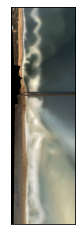

In [7]:
rect_frame = cf.mergeRectify(image_list, cameras, grid)

# Display our rectified frame
fig, axs = plt.subplots(1)
axs.xaxis.set_visible(False)
axs.yaxis.set_visible(False)
axs.imshow(rect_frame.astype(np.uint8), 
        cmap="gray",
        vmin=0,
        vmax=255
    )
plt.show()

### Rectifying Multiple Oblique Frames

What if we want to rectify a sequence of oblique frames, for example, videos that have been converted to single frames, then save to one merged video file?

In this case, we need to set up a loop to go through each *timestamp* of the frames, and merge all the cameras at that *timestamp*, then save each merged frame into a videwriter object.

Ultimately, you will have to write your own for loop to accomodate your specific application.

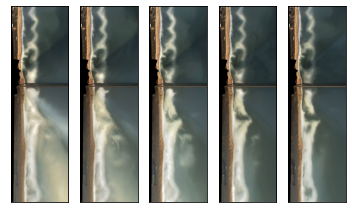

Video saved to current working directory as: ExampleData\Oct.08.2015_timex_merged.avi


In [8]:
# Here, we will only work with 5 frames per camera

start_time = 1444314601 # Timestamp of the first frame, in UTC time
end_time = 1444323601 # Timestamp of the last frame, in UTC time

# The timestamp of each frame is contained in the file name
# For this example data, the images are time averaged and sampled every 30 minutes
# Therefore, we are looking for the time stamps in epoch time at every 1800 seconds
file_changes = np.arange(start_time, end_time, 1800)
fig, axs = plt.subplots(1, len(file_changes))

for ind, f in enumerate(file_changes):
    paths, outFile = sf.formatArgusFile(cams, "", f, file_ext = '.timex.jpg', folder_tag = False)
    outFile = os.path.join(folder,'Oct.08.2015_timex_merged.avi')
    fullpaths = [os.path.join(folder,i,p) for i,p in zip(cams,paths)]
    rect_frame = cf.mergeRectify(fullpaths, cameras, grid)
    
    # Display the current frame
    disp_str = 'Merged and Rectified Frame ' + str(f)

    axs[ind].xaxis.set_visible(False)
    axs[ind].yaxis.set_visible(False)
    axs[ind].imshow(rect_frame.astype(np.uint8), 
        cmap="gray",
        vmin=0,
        vmax=255
    )

    # Save rectified video to drive
    if f == start_time:
        # Initialize openCV videowriter object
        out = cv.VideoWriter(outFile,cv.VideoWriter_fourcc('M','J','P','G'), 2, (np.shape(rect_frame)[1],np.shape(rect_frame)[0]),0)
        all_frames = rect_frame
        
    # Write frame to .avi
    out.write(rect_frame.astype(np.uint8))

    # Saving array with all frames to use in last step of tutorial (image statistics)
    all_frames = np.dstack((all_frames,rect_frame))

# Release videowriter object
out.release()
plt.show()
print('Video saved to current working directory as: ' + outFile)
    

### Rectifying Oblique Videos
#### *Due to the limitations in large file storage on GitHub, full length example video files are not included in the ExampleData folder. In order to utilize this section, please reach out to the author (Maile McCann, mailemcc@usc.edu) for example video files. Otherwise, load your own .avi files via the video_list path.*

Finally, let's rectify our videos!

numFrames is the number of frames we would like to rectify. Here, our video is sampled at 2 Hz, and we would like 10 seconds of data. Therefore, numFrames = 2*10

In [11]:
numFrames = 20 # 2 fps for 10 seconds

video_list = [os.path.join(folder,i,(file_base + i + '.avi')) for i in cams]
# Call rectVideos

#rect = cf.rectVideos(video_list, cameras, grid, numFrames)

Now, you have an object containing your rectified frames. However, your video is also saved to your drive in your working directory as the input file name + 'video_capture.rect.avi'.

### Creating a Pixel Timestack

Let's create subsampled pixel timestacks. These timestacks are for use in algorithms such as bathymetric inversion, surface current estimation, or run-up calculations. Pixel timestacks show variations in pixel intensity over time.

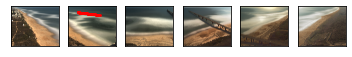

In [ ]:
# Here, we will create one pixel stack at a single timestamp and display the location on oblique images

# Ultimately, you will need to write your own for loop to accomodate your specific application

# Click 'x' to exit image displays

# Alongshore Transect
x = 300
yMin = 900
yMax = 1200
dy = 5
alongshore_trans = cf.XYZGrid([x], [yMin,yMax], dx, dy, z)

start_time = 1444314601 # Timestamp of the first frame, in UTC time
paths, outFile = sf.formatArgusFile(cams,"",start_time,file_ext = '.timex.jpg', folder_tag = False)
fullpaths = [os.path.join(folder,i,p) for i,p in zip(cams,paths)]
rect = cf.pixelStack(fullpaths, alongshore_trans, cameras, disp_flag=1)

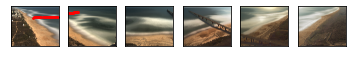

In [ ]:
# Cross- shore Transect
xMin = 100
xMax = 300
y = 1200
dx = 5
alongshore_trans = cf.XYZGrid([xMin, xMax], [y], dx, dy, z)
rect = cf.pixelStack(fullpaths, alongshore_trans, cameras, disp_flag=1)


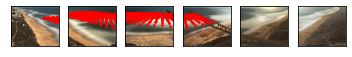

In [ ]:
# Pixel Grid
xMin = 150
xMax = 400
yMin = 500
yMax = 1200
dx = 20
dy = 20
pix_grid = cf.XYZGrid([xMin, xMax], [yMin, yMax], dx, dy, z)
rect = cf.pixelStack(fullpaths, pix_grid, cameras, disp_flag=1)

### Calculating Image Statistics

Lastly, let's calculate sample statistical image products. These products include Darkest, Brightest, Timex, and Variance from an array of images. For detailed information, see the accompanying SoftwareX publication, or the CoastalImageLib User Manual.

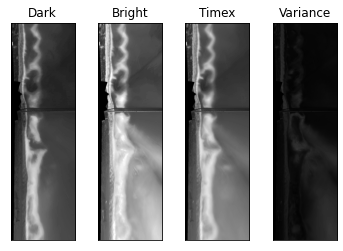

In [10]:
# Let's find the image statistics from the rectified array, "all_frames" we created in "Rectifying Multiple Oblique Frames"
# Save flag indicates that the resulting image products will NOT be saved 
# in the current working directory

cf.imageStats(all_frames, save_flag = 0, disp_flag = 1)